## 1. Setup & Import Libraries

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")

Project root: C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Print versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 1.24.3
Pandas version: 2.0.3


In [3]:
# Import our semi-supervised module
from src.models.semi_supervised import (
    # Split functions
    create_labeled_unlabeled_split,
    create_multiple_splits,
    
    # Training functions
    train_self_training,
    train_self_training_rf,
    train_label_propagation,
    train_label_spreading,
    
    # Analysis
    analyze_pseudo_labels,
    evaluate_semi_supervised,
    
    # Comparison
    compare_semi_supervised_methods,
    run_label_fraction_experiment,
    
    # Visualization
    plot_learning_curve_by_labels,
    plot_pseudo_label_confusion_matrix
)

print("✅ Semi-supervised module imported successfully!")

✅ Semi-supervised module imported successfully!


## 2. Load Data

In [4]:
# Load processed data
data_dir = os.path.join(project_root, 'data', 'processed')

# Training data (with SMOTE resampling from Phase 4)
X_train = pd.read_csv(os.path.join(data_dir, 'X_train_resampled.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train_resampled.csv')).squeeze()

# Test data
X_test = pd.read_csv(os.path.join(data_dir, 'X_test_encoded.csv'))
y_test = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).squeeze()

print(f"📊 Data Loaded:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape:  {X_test.shape}")
print(f"   y_test shape:  {y_test.shape}")
print(f"\n   Train class distribution:")
print(f"   {y_train.value_counts().to_dict()}")

📊 Data Loaded:
   X_train shape: (120266, 40)
   y_train shape: (120266,)
   X_test shape:  (23878, 286)
   y_test shape:  (23878,)

   Train class distribution:
   {0: 60133, 1: 60133}


In [5]:
# Ensure columns match between train and test
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

if train_cols != test_cols:
    # Find common columns
    common_cols = list(train_cols.intersection(test_cols))
    print(f"⚠️ Column mismatch! Using {len(common_cols)} common columns.")
    
    # Show differences
    only_train = train_cols - test_cols
    only_test = test_cols - train_cols
    if only_train:
        print(f"   Only in train: {only_train}")
    if only_test:
        print(f"   Only in test: {only_test}")
    
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
else:
    print("✅ Columns match between train and test")

⚠️ Column mismatch! Using 40 common columns.
   Only in test: {'arrival_date_month_February', 'lead_time_category_7-30ngay', 'country_BFA', 'country_TJK', 'country_LIE', 'adr_category_Luxury', 'meal_HB', 'country_MDV', 'country_SRB', 'country_GLP', 'country_GBR', 'country_IND', 'country_BEL', 'country_NIC', 'country_PLW', 'country_KNA', 'reserved_room_type_G', 'country_FIN', 'country_NLD', 'lead_time_category_365+ngay', 'country_ETH', 'country_LBY', 'country_grouped_DEU', 'country_GTM', 'country_CHL', 'country_CUB', 'country_NPL', 'country_MRT', 'country_grouped_IRL', 'market_segment_Undefined', 'country_KAZ', 'country_ZMB', 'country_TUR', 'country_ATA', 'country_CHE', 'adr_category_Standard', 'country_DMA', 'country_EGY', 'country_NZL', 'country_JEY', 'country_VNM', 'reserved_room_type_B', 'country_FRO', 'assigned_room_type_P', 'country_IRQ', 'country_CIV', 'market_segment_Complementary', 'country_CYM', 'arrival_date_month_November', 'country_DJI', 'country_MKD', 'country_SDN', 'arriv

In [6]:
# For semi-supervised experiments, use smaller subset for efficiency
# (Label Propagation/Spreading can be slow on very large datasets)

SAMPLE_SIZE = 20000  # Use subset for faster experiments

if len(X_train) > SAMPLE_SIZE:
    print(f"📉 Sampling {SAMPLE_SIZE:,} samples from {len(X_train):,} for faster experiments...")
    
    # Stratified sampling
    from sklearn.model_selection import train_test_split
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train,
        train_size=SAMPLE_SIZE,
        stratify=y_train,
        random_state=42
    )
    
    print(f"   Sampled X_train: {X_train_sample.shape}")
    print(f"   Sampled y_train: {y_train_sample.shape}")
    print(f"   Class distribution: {y_train_sample.value_counts().to_dict()}")
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print(f"✅ Using full training data: {len(X_train):,} samples")

📉 Sampling 20,000 samples from 120,266 for faster experiments...
   Sampled X_train: (20000, 40)
   Sampled y_train: (20000,)
   Class distribution: {0: 10000, 1: 10000}


## 3. Create Labeled/Unlabeled Splits

Giả lập tình huống chỉ có một phần nhỏ dữ liệu được gán nhãn.

In [7]:
# Create splits with different labeled fractions
label_fractions = [0.05, 0.10, 0.20]

splits = create_multiple_splits(
    X_train_sample, y_train_sample,
    fractions=label_fractions,
    random_state=42,
    verbose=True
)

CREATING MULTIPLE SPLITS
   5% labeled: 1,000 samples
   10% labeled: 2,000 samples
   20% labeled: 4,000 samples


In [8]:
# Detailed view of 10% split
X, y_semi_10, mask_10 = splits[0.10]

print("\n📊 Detailed 10% Split:")
print(f"   Total samples: {len(y_semi_10):,}")
print(f"   Labeled (y != -1): {(y_semi_10 != -1).sum():,}")
print(f"   Unlabeled (y == -1): {(y_semi_10 == -1).sum():,}")
print(f"\n   First 20 labels: {y_semi_10[:20]}")


📊 Detailed 10% Split:
   Total samples: 20,000
   Labeled (y != -1): 2,000
   Unlabeled (y == -1): 18,000

   First 20 labels: [ 0. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1.
 -1. -1.]


## 4. Self-Training

Self-Training hoạt động:
1. Huấn luyện model trên dữ liệu đã gán nhãn
2. Dự đoán trên dữ liệu chưa gán nhãn
3. Thêm các dự đoán có độ tin cậy cao (>= threshold) vào tập labeled
4. Lặp lại cho đến khi hội tụ

In [9]:
# Train Self-Training with 10% labeled data
X_10, y_semi_10, mask_10 = splits[0.10]

print("="*70)
print("SELF-TRAINING WITH LOGISTIC REGRESSION (threshold=0.9)")
print("="*70)

model_st_lr, info_st_lr = train_self_training(
    X_10, y_semi_10,
    threshold=0.9,
    verbose=True
)

SELF-TRAINING WITH LOGISTIC REGRESSION (threshold=0.9)
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10


Initial labeled: 2,000
Initial unlabeled: 18,000


End of iteration 1, added 6445 new labels.


End of iteration 2, added 2203 new labels.


End of iteration 3, added 777 new labels.


End of iteration 4, added 600 new labels.


End of iteration 5, added 320 new labels.


End of iteration 6, added 665 new labels.


End of iteration 7, added 239 new labels.


End of iteration 8, added 130 new labels.


End of iteration 9, added 117 new labels.


End of iteration 10, added 143 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 11,639
   Final labeled: 13,639 (68.2%)


In [10]:
# Evaluate Self-Training model on test set
metrics_st_lr = evaluate_semi_supervised(
    model_st_lr, X_test, y_test,
    model_name="Self-Training (LR, threshold=0.9)",
    verbose=True
)


📊 Self-Training (LR, threshold=0.9) Evaluation:
   Accuracy:  0.7465
   Precision: 0.6444
   Recall:    0.7047
   F1 Score:  0.6732
   ROC-AUC:   0.8181
   PR-AUC:    0.7763


In [11]:
# Self-Training with higher threshold (more conservative)
print("\n" + "="*70)
print("SELF-TRAINING WITH HIGHER THRESHOLD (0.95)")
print("="*70)

model_st_95, info_st_95 = train_self_training(
    X_10, y_semi_10,
    threshold=0.95,
    verbose=True
)

metrics_st_95 = evaluate_semi_supervised(
    model_st_95, X_test, y_test,
    model_name="Self-Training (threshold=0.95)",
    verbose=True
)


SELF-TRAINING WITH HIGHER THRESHOLD (0.95)
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.95
Max iterations: 10
Initial labeled: 2,000
Initial unlabeled: 18,000


End of iteration 1, added 5058 new labels.


End of iteration 2, added 1022 new labels.


End of iteration 3, added 851 new labels.


End of iteration 4, added 226 new labels.


End of iteration 5, added 169 new labels.


End of iteration 6, added 128 new labels.


End of iteration 7, added 121 new labels.


End of iteration 8, added 125 new labels.


End of iteration 9, added 27 new labels.


End of iteration 10, added 51 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 7,778
   Final labeled: 9,778 (48.9%)

📊 Self-Training (threshold=0.95) Evaluation:
   Accuracy:  0.7529
   Precision: 0.6489
   Recall:    0.7252
   F1 Score:  0.6849
   ROC-AUC:   0.8322
   PR-AUC:    0.7955


In [12]:
# Compare thresholds
print("\n📊 Self-Training Threshold Comparison (10% labeled):")
print(f"   Threshold 0.90: F1={metrics_st_lr['f1']:.4f}, Pseudo-labels={info_st_lr['n_pseudo_labeled']:,}")
print(f"   Threshold 0.95: F1={metrics_st_95['f1']:.4f}, Pseudo-labels={info_st_95['n_pseudo_labeled']:,}")


📊 Self-Training Threshold Comparison (10% labeled):
   Threshold 0.90: F1=0.6732, Pseudo-labels=11,639
   Threshold 0.95: F1=0.6849, Pseudo-labels=7,778


## 5. Pseudo-Label Analysis

Phân tích chất lượng của pseudo-labels so với ground truth.

In [13]:
# Analyze pseudo-label quality for Self-Training
# Get the transduced labels (after self-training)
y_pseudo_st = model_st_lr.transduction_

# Mask for originally unlabeled samples
mask_unlabeled = ~mask_10

# Analyze
pseudo_analysis = analyze_pseudo_labels(
    y_true=y_train_sample.values,
    y_pseudo=y_pseudo_st,
    mask_unlabeled=mask_unlabeled,
    X=X_train_sample,
    feature_to_analyze='lead_time' if 'lead_time' in X_train_sample.columns else None,
    verbose=True
)


PSEUDO-LABEL ANALYSIS

📊 Pseudo-Label Quality:
   Originally unlabeled: 18,000
   Pseudo-labeled: 11,639
   Still unlabeled: 6,361

   Accuracy:  0.8614
   Precision: 0.8837
   Recall:    0.8431
   F1 Score:  0.8629

❌ Errors (on pseudo-labeled samples):
   Total errors: 1,613 (13.86%)
   False Positives: 668 (predicted cancel, actually not)
   False Negatives: 945 (predicted not cancel, actually cancel)

📋 Confusion Matrix:
   TN=4,949  FP=668
   FN=945  TP=5,077

📈 Error Rate by lead_time:
   Q1: 11.87% (347/2923 errors)
   Q2: 16.07% (466/2900 errors)
   Q3: 15.61% (455/2915 errors)
   Q4: 11.89% (345/2901 errors)


✅ Saved confusion matrix to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\pseudo_label_cm_self_training.png


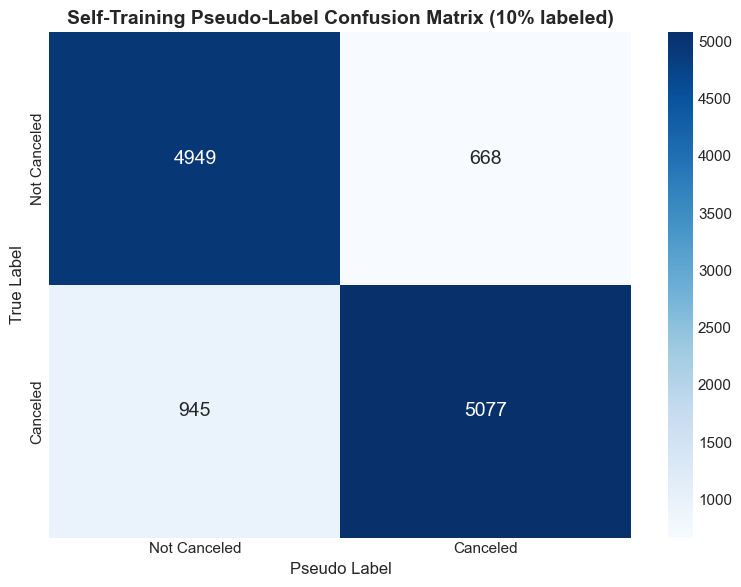

In [14]:
# Plot pseudo-label confusion matrix
fig = plot_pseudo_label_confusion_matrix(
    y_true=y_train_sample.values,
    y_pseudo=y_pseudo_st,
    mask_unlabeled=mask_unlabeled,
    title='Self-Training Pseudo-Label Confusion Matrix (10% labeled)',
    save_path=os.path.join(project_root, 'outputs', 'figures', 'pseudo_label_cm_self_training.png'),
    show=True
)

## 6. Label Propagation & Spreading

Các phương pháp graph-based semi-supervised learning.

In [15]:
# Use smaller sample for Label Propagation (memory intensive)
LABEL_PROP_SAMPLE = min(10000, len(X_train_sample))

if len(X_train_sample) > LABEL_PROP_SAMPLE:
    from sklearn.model_selection import train_test_split
    X_lp, _, y_lp, _ = train_test_split(
        X_train_sample, y_train_sample,
        train_size=LABEL_PROP_SAMPLE,
        stratify=y_train_sample,
        random_state=42
    )
    print(f"📉 Using {LABEL_PROP_SAMPLE:,} samples for Label Propagation")
else:
    X_lp = X_train_sample
    y_lp = y_train_sample

# Create 10% split for label propagation
X_lp, y_semi_lp, mask_lp = create_labeled_unlabeled_split(
    X_lp, y_lp,
    labeled_fraction=0.10,
    random_state=42,
    verbose=True
)

📉 Using 10,000 samples for Label Propagation
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 10.0%
Target labeled samples: 1,000

📊 Split Result:
   Labeled samples: 1,000 (10.0%)
   Unlabeled samples: 9,000 (90.0%)

   Labeled class distribution:
      Class 0: 500 (50.0%)
      Class 1: 500 (50.0%)


In [16]:
# Train Label Propagation with KNN kernel
print("\n" + "="*70)
print("LABEL PROPAGATION (KNN kernel)")
print("="*70)

model_lp, info_lp = train_label_propagation(
    X_lp, y_semi_lp,
    kernel='knn',
    n_neighbors=7,
    verbose=True
)

# Evaluate
metrics_lp = evaluate_semi_supervised(
    model_lp, X_test, y_test,
    model_name="Label Propagation (KNN)",
    verbose=True
)


LABEL PROPAGATION (KNN kernel)
TRAINING LABEL PROPAGATION
Kernel: knn
N neighbors: 7
Labeled samples: 1,000
Unlabeled samples: 9,000



📊 Label Propagation Results:
   Iterations: 1000



📊 Label Propagation (KNN) Evaluation:
   Accuracy:  0.5651
   Precision: 0.4375
   Recall:    0.6097
   F1 Score:  0.5095


In [17]:
# Train Label Spreading
print("\n" + "="*70)
print("LABEL SPREADING (KNN kernel, alpha=0.2)")
print("="*70)

model_ls, info_ls = train_label_spreading(
    X_lp, y_semi_lp,
    kernel='knn',
    n_neighbors=7,
    alpha=0.2,
    verbose=True
)

# Evaluate
metrics_ls = evaluate_semi_supervised(
    model_ls, X_test, y_test,
    model_name="Label Spreading (KNN, alpha=0.2)",
    verbose=True
)


LABEL SPREADING (KNN kernel, alpha=0.2)
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 1,000
Unlabeled samples: 9,000

📊 Label Spreading Results:
   Iterations: 8



📊 Label Spreading (KNN, alpha=0.2) Evaluation:
   Accuracy:  0.5745
   Precision: 0.4428
   Recall:    0.5756
   F1 Score:  0.5006


## 7. Comparison: Supervised vs Semi-Supervised

In [18]:
# Compare methods at 10% labeled
print("\n" + "#"*70)
print("# COMPARISON: SUPERVISED vs SEMI-SUPERVISED (10% labeled)")
print("#"*70)

comparison_10 = compare_semi_supervised_methods(
    X_lp, y_lp, X_test, y_test,
    labeled_fraction=0.10,
    methods=['supervised', 'self_training', 'label_spreading'],
    random_state=42,
    verbose=True
)


######################################################################
# COMPARISON: SUPERVISED vs SEMI-SUPERVISED (10% labeled)
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 10.0%
Target labeled samples: 1,000

📊 Split Result:
   Labeled samples: 1,000 (10.0%)
   Unlabeled samples: 9,000 (90.0%)

   Labeled class distribution:
      Class 0: 500 (50.0%)
      Class 1: 500 (50.0%)

Training: SUPERVISED



📊 supervised Evaluation:
   Accuracy:  0.7464
   Precision: 0.6388
   Recall:    0.7256
   F1 Score:  0.6794
   ROC-AUC:   0.8297
   PR-AUC:    0.7938

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 1,000
Initial unlabeled: 9,000
End of iteration 1, added 3233 new labels.


End of iteration 2, added 853 new labels.


End of iteration 3, added 319 new labels.


End of iteration 4, added 161 new labels.


End of iteration 5, added 226 new labels.


End of iteration 6, added 278 new labels.


End of iteration 7, added 201 new labels.


End of iteration 8, added 60 new labels.


End of iteration 9, added 115 new labels.


End of iteration 10, added 133 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 5,579
   Final labeled: 6,579 (65.8%)

📊 self_training Evaluation:
   Accuracy:  0.7427
   Precision: 0.6320
   Recall:    0.7309
   F1 Score:  0.6779
   ROC-AUC:   0.8236
   PR-AUC:    0.7865

Training: LABEL_SPREADING
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 1,000
Unlabeled samples: 9,000

📊 Label Spreading Results:
   Iterations: 8



📊 label_spreading Evaluation:
   Accuracy:  0.5745
   Precision: 0.4428
   Recall:    0.5756
   F1 Score:  0.5006

COMPARISON SUMMARY (10% labeled)
                 accuracy  precision  recall      f1  roc_auc  pr_auc
supervised         0.7464     0.6388  0.7256  0.6794   0.8297  0.7938
self_training      0.7427     0.6320  0.7309  0.6779   0.8236  0.7865
label_spreading    0.5745     0.4428  0.5756  0.5006      NaN     NaN


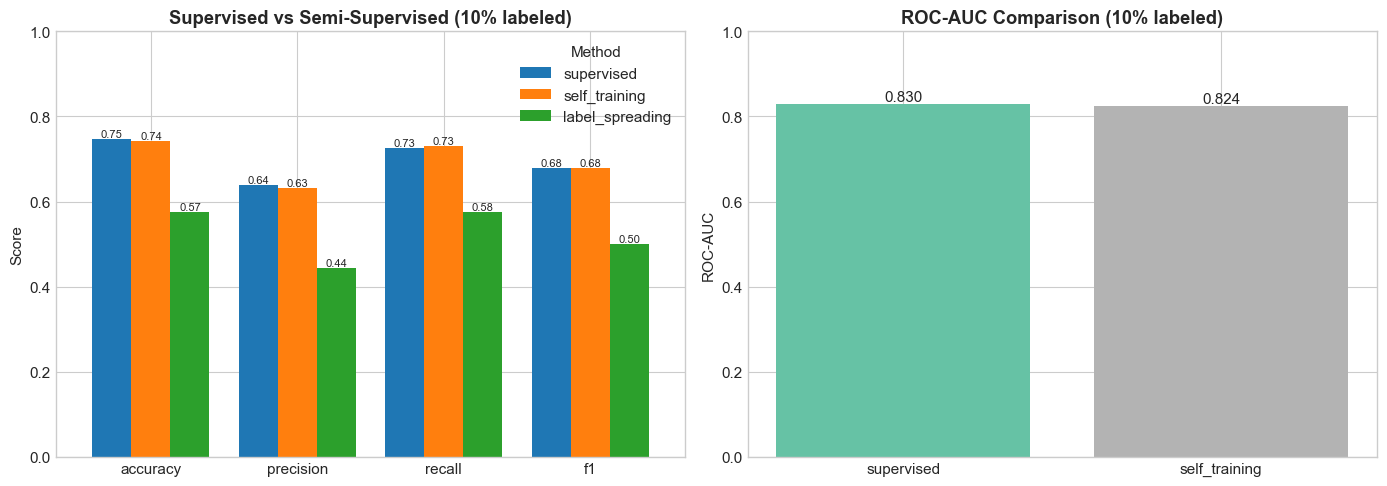


✅ Figure saved to outputs/figures/semi_supervised_comparison.png


In [19]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
comparison_plot = comparison_10[metrics_to_plot].T

comparison_plot.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
axes[0].set_title('Supervised vs Semi-Supervised (10% labeled)', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(title='Method')
axes[0].set_ylim(0, 1)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=8)

# ROC-AUC if available
if 'roc_auc' in comparison_10.columns:
    roc_data = comparison_10['roc_auc'].dropna()
    colors = plt.cm.Set2(np.linspace(0, 1, len(roc_data)))
    bars = axes[1].bar(roc_data.index, roc_data.values, color=colors)
    axes[1].set_title('ROC-AUC Comparison (10% labeled)', fontweight='bold')
    axes[1].set_ylabel('ROC-AUC')
    axes[1].set_ylim(0, 1)
    axes[1].bar_label(bars, fmt='%.3f')
else:
    axes[1].text(0.5, 0.5, 'ROC-AUC not available', ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'outputs', 'figures', 'semi_supervised_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to outputs/figures/semi_supervised_comparison.png")

## 8. Label Fraction Experiment (5%, 10%, 20%)

In [20]:
# Run experiments across different label fractions
print("\n" + "#"*70)
print("# LABEL FRACTION EXPERIMENT")
print("#"*70)

# Use smaller data for efficiency
experiment_results = run_label_fraction_experiment(
    X_lp, y_lp, X_test, y_test,
    fractions=[0.05, 0.10, 0.20],
    random_state=42,
    verbose=True
)


######################################################################
# LABEL FRACTION EXPERIMENT
######################################################################

######################################################################
# EXPERIMENT: 5% LABELED DATA
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 5.0%
Target labeled samples: 500

📊 Split Result:
   Labeled samples: 500 (5.0%)
   Unlabeled samples: 9,500 (95.0%)

   Labeled class distribution:
      Class 0: 250 (50.0%)
      Class 1: 250 (50.0%)

Training: SUPERVISED



📊 supervised Evaluation:


   Accuracy:  0.7553
   Precision: 0.6565
   Recall:    0.7118
   F1 Score:  0.6830
   ROC-AUC:   0.8300
   PR-AUC:    0.7907

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 500
Initial unlabeled: 9,500
End of iteration 1, added 3083 new labels.


End of iteration 2, added 1509 new labels.


End of iteration 3, added 770 new labels.


End of iteration 4, added 438 new labels.


End of iteration 5, added 400 new labels.


End of iteration 6, added 406 new labels.


End of iteration 7, added 120 new labels.


End of iteration 8, added 256 new labels.


End of iteration 9, added 67 new labels.


End of iteration 10, added 68 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 7,117
   Final labeled: 7,617 (76.2%)

📊 self_training Evaluation:
   Accuracy:  0.7540
   Precision: 0.6563
   Recall:    0.7055
   F1 Score:  0.6800
   ROC-AUC:   0.8204
   PR-AUC:    0.7798

Training: LABEL_SPREADING
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 500
Unlabeled samples: 9,500

📊 Label Spreading Results:
   Iterations: 7



📊 label_spreading Evaluation:
   Accuracy:  0.5637
   Precision: 0.4252
   Recall:    0.5050
   F1 Score:  0.4617

COMPARISON SUMMARY (5% labeled)
                 accuracy  precision  recall      f1  roc_auc  pr_auc
supervised         0.7553     0.6565  0.7118  0.6830   0.8300  0.7907
self_training      0.7540     0.6563  0.7055  0.6800   0.8204  0.7798
label_spreading    0.5637     0.4252  0.5050  0.4617      NaN     NaN

######################################################################
# EXPERIMENT: 10% LABELED DATA
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 10.0%
Target labeled samples: 1,000

📊 Split Result:
   Labeled samples: 1,000 (10.0%)
   Unlabeled samples: 9,000 (90.0%)

   Labeled class distribution:
      Class 0: 500 (50.0%)
      Class 1: 500 (50.0%)

Training: SUPERVISED



📊 supervised Evaluation:
   Accuracy:  0.7464
   Precision: 0.6388
   Recall:    0.7256
   F1 Score:  0.6794
   ROC-AUC:   0.8297
   PR-AUC:    0.7938

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 1,000
Initial unlabeled: 9,000
End of iteration 1, added 3233 new labels.


End of iteration 2, added 853 new labels.


End of iteration 3, added 319 new labels.


End of iteration 4, added 161 new labels.


End of iteration 5, added 226 new labels.


End of iteration 6, added 278 new labels.


End of iteration 7, added 201 new labels.


End of iteration 8, added 60 new labels.


End of iteration 9, added 115 new labels.


End of iteration 10, added 133 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 5,579
   Final labeled: 6,579 (65.8%)

📊 self_training Evaluation:
   Accuracy:  0.7427
   Precision: 0.6320
   Recall:    0.7309
   F1 Score:  0.6779
   ROC-AUC:   0.8236
   PR-AUC:    0.7865

Training: LABEL_SPREADING
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 1,000
Unlabeled samples: 9,000

📊 Label Spreading Results:
   Iterations: 8



📊 label_spreading Evaluation:
   Accuracy:  0.5745
   Precision: 0.4428
   Recall:    0.5756
   F1 Score:  0.5006

COMPARISON SUMMARY (10% labeled)
                 accuracy  precision  recall      f1  roc_auc  pr_auc
supervised         0.7464     0.6388  0.7256  0.6794   0.8297  0.7938
self_training      0.7427     0.6320  0.7309  0.6779   0.8236  0.7865
label_spreading    0.5745     0.4428  0.5756  0.5006      NaN     NaN

######################################################################
# EXPERIMENT: 20% LABELED DATA
######################################################################
CREATING LABELED/UNLABELED SPLIT
Total samples: 10,000
Labeled fraction: 20.0%
Target labeled samples: 2,000

📊 Split Result:
   Labeled samples: 2,000 (20.0%)
   Unlabeled samples: 8,000 (80.0%)

   Labeled class distribution:
      Class 0: 1,000 (50.0%)
      Class 1: 1,000 (50.0%)

Training: SUPERVISED



📊 supervised Evaluation:
   Accuracy:  0.7492
   Precision: 0.6449
   Recall:    0.7187
   F1 Score:  0.6798
   ROC-AUC:   0.8300
   PR-AUC:    0.7932

Training: SELF_TRAINING
TRAINING SELF-TRAINING CLASSIFIER
Confidence threshold: 0.9
Max iterations: 10
Initial labeled: 2,000
Initial unlabeled: 8,000
End of iteration 1, added 3028 new labels.


End of iteration 2, added 349 new labels.


End of iteration 3, added 344 new labels.


End of iteration 4, added 17 new labels.


End of iteration 5, added 75 new labels.


End of iteration 6, added 168 new labels.


End of iteration 7, added 23 new labels.


End of iteration 8, added 24 new labels.


End of iteration 9, added 7 new labels.


End of iteration 10, added 146 new labels.



📊 Self-Training Results:
   Iterations: 10
   Termination: max_iter
   Pseudo-labels added: 4,181
   Final labeled: 6,181 (61.8%)

📊 self_training Evaluation:
   Accuracy:  0.7487
   Precision: 0.6438
   Recall:    0.7198
   F1 Score:  0.6797
   ROC-AUC:   0.8230
   PR-AUC:    0.7855

Training: LABEL_SPREADING
TRAINING LABEL SPREADING
Kernel: knn
Alpha (clamping): 0.2
Labeled samples: 2,000
Unlabeled samples: 8,000

📊 Label Spreading Results:
   Iterations: 8



📊 label_spreading Evaluation:
   Accuracy:  0.6081
   Precision: 0.4780
   Recall:    0.6286
   F1 Score:  0.5430

COMPARISON SUMMARY (20% labeled)
                 accuracy  precision  recall      f1  roc_auc  pr_auc
supervised         0.7492     0.6449  0.7187  0.6798    0.830  0.7932
self_training      0.7487     0.6438  0.7198  0.6797    0.823  0.7855
label_spreading    0.6081     0.4780  0.6286  0.5430      NaN     NaN


✅ Saved learning curve to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\semi_supervised_learning_curve.png


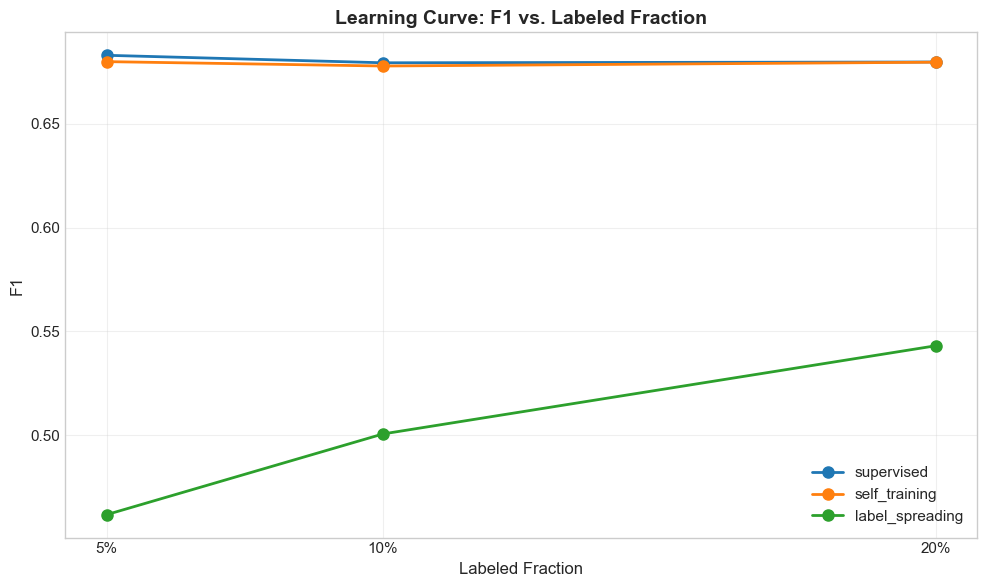

In [21]:
# Plot learning curve
fig = plot_learning_curve_by_labels(
    experiment_results,
    metric='f1',
    figsize=(10, 6),
    save_path=os.path.join(project_root, 'outputs', 'figures', 'semi_supervised_learning_curve.png'),
    show=True
)

In [22]:
# Summary table
print("\n" + "="*70)
print("SUMMARY: F1 SCORES BY LABELED FRACTION")
print("="*70)

summary_data = {}
for frac, results in experiment_results.items():
    if 'f1' in results.columns:
        summary_data[f'{frac:.0%} labeled'] = results['f1'].to_dict()

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4).to_string())

# Save summary
summary_df.to_csv(os.path.join(project_root, 'outputs', 'tables', 'semi_supervised_summary.csv'))
print("\n✅ Summary saved to outputs/tables/semi_supervised_summary.csv")


SUMMARY: F1 SCORES BY LABELED FRACTION
                 5% labeled  10% labeled  20% labeled
supervised           0.6830       0.6794       0.6798
self_training        0.6800       0.6779       0.6797
label_spreading      0.4617       0.5006       0.5430

✅ Summary saved to outputs/tables/semi_supervised_summary.csv


## 9. Key Findings & Conclusions

In [23]:
# Final analysis
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

# Find best method for each fraction
for frac, results in experiment_results.items():
    if 'f1' in results.columns:
        best_method = results['f1'].idxmax()
        best_f1 = results['f1'].max()
        supervised_f1 = results.loc['supervised', 'f1'] if 'supervised' in results.index else 0
        
        improvement = (best_f1 - supervised_f1) / supervised_f1 * 100 if supervised_f1 > 0 else 0
        
        print(f"\n📊 {frac:.0%} Labeled Data:")
        print(f"   Best method: {best_method} (F1={best_f1:.4f})")
        print(f"   Supervised baseline: F1={supervised_f1:.4f}")
        if improvement > 0:
            print(f"   Improvement: +{improvement:.1f}%")
        else:
            print(f"   Difference: {improvement:.1f}%")


KEY FINDINGS

📊 5% Labeled Data:
   Best method: supervised (F1=0.6830)
   Supervised baseline: F1=0.6830
   Difference: 0.0%

📊 10% Labeled Data:
   Best method: supervised (F1=0.6794)
   Supervised baseline: F1=0.6794
   Difference: 0.0%

📊 20% Labeled Data:
   Best method: supervised (F1=0.6798)
   Supervised baseline: F1=0.6798
   Difference: 0.0%


In [24]:
# Conclusions
print("\n" + "="*70)
print("CONCLUSIONS")
print("="*70)
print("""
1. SELF-TRAINING:
   - Hiệu quả khi có ít labeled data (5-10%)
   - Threshold cao (0.95) cho pseudo-labels chính xác hơn nhưng ít hơn
   - Threshold thấp (0.9) cho nhiều pseudo-labels hơn nhưng có thể sai

2. LABEL PROPAGATION / SPREADING:
   - Hoạt động tốt khi cấu trúc cluster rõ ràng
   - Tốn nhiều bộ nhớ cho dataset lớn
   - KNN kernel thường ổn định hơn RBF

3. SO SÁNH VỚI SUPERVISED:
   - Semi-supervised có thể cải thiện khi labeled data rất ít
   - Với >20% labeled, supervised thường đủ tốt
   - Chất lượng pseudo-labels rất quan trọng

4. KHUYẾN NGHỊ:
   - Sử dụng Self-Training khi có 5-15% labeled data
   - Bắt đầu với threshold cao (0.95), giảm nếu cần
   - Luôn validate pseudo-labels khi có thể
""")


CONCLUSIONS

1. SELF-TRAINING:
   - Hiệu quả khi có ít labeled data (5-10%)
   - Threshold cao (0.95) cho pseudo-labels chính xác hơn nhưng ít hơn
   - Threshold thấp (0.9) cho nhiều pseudo-labels hơn nhưng có thể sai

2. LABEL PROPAGATION / SPREADING:
   - Hoạt động tốt khi cấu trúc cluster rõ ràng
   - Tốn nhiều bộ nhớ cho dataset lớn
   - KNN kernel thường ổn định hơn RBF

3. SO SÁNH VỚI SUPERVISED:
   - Semi-supervised có thể cải thiện khi labeled data rất ít
   - Với >20% labeled, supervised thường đủ tốt
   - Chất lượng pseudo-labels rất quan trọng

4. KHUYẾN NGHỊ:
   - Sử dụng Self-Training khi có 5-15% labeled data
   - Bắt đầu với threshold cao (0.95), giảm nếu cần
   - Luôn validate pseudo-labels khi có thể



---

## 📝 Notebook Complete

Phase 6: Semi-Supervised Learning đã hoàn thành!

**Outputs:**
- `outputs/figures/pseudo_label_cm_self_training.png`
- `outputs/figures/semi_supervised_comparison.png`
- `outputs/figures/semi_supervised_learning_curve.png`
- `outputs/tables/semi_supervised_summary.csv`